# Imports 

In [1]:
!pip3 install ezdxf
#!git clone https://github.com/JarvisSan22/Unet_CrackExtract_to_dxf.git


     |████████████████████████████████| 2.5 MB 5.6 MB/s eta 0:00:01


In [27]:
import tensorflow as tf
import os
import glob
import numpy as np
import shutil
from patchify import patchify, unpatchify
import random
import cv2
import matplotlib.pyplot as plt
from tqdm import tqdm  #Progress bar for loops 
from skimage.io import imread, imshow
from skimage.color import rgb2gray
from skimage.transform import resize
import random
import numpy as np
import ezdxf 

Driaveをロードする

In [3]:
#from google.colab import drive
#drive.mount('/content/drive')

Mounted at /content/drive


#画像の処理


In [10]:
#Image file collect 画像のファイルを集まる
TRAIN_PATH=os.getcwd()+"/data/DeepCrack/train"
TEST_PATH=os.getcwd()+"/data/DeepCrack/test"
train_files=glob.glob(TRAIN_PATH+"/image/***.jpg")
train_labels=glob.glob(TRAIN_PATH+"/label/***.png")
test_files=glob.glob(TEST_PATH+"/test_img/***.jpg")
print(len(train_files),len(train_labels),len(test_files))

300 300 237


In [11]:
train_labels=sorted(train_labels)
train_files=sorted(train_files)

In [13]:
print(len(train_files),len(train_labels))
train_files[0:4],train_labels[0:4]

300 300


(['/home/jarvis/Documents/personal/Unet_CrackExtract_to_dxf/data/DeepCrack/train/image/11111.jpg',
  '/home/jarvis/Documents/personal/Unet_CrackExtract_to_dxf/data/DeepCrack/train/image/11112.jpg',
  '/home/jarvis/Documents/personal/Unet_CrackExtract_to_dxf/data/DeepCrack/train/image/11113.jpg',
  '/home/jarvis/Documents/personal/Unet_CrackExtract_to_dxf/data/DeepCrack/train/image/11114.jpg'],
 ['/home/jarvis/Documents/personal/Unet_CrackExtract_to_dxf/data/DeepCrack/train/label/11111.png',
  '/home/jarvis/Documents/personal/Unet_CrackExtract_to_dxf/data/DeepCrack/train/label/11112.png',
  '/home/jarvis/Documents/personal/Unet_CrackExtract_to_dxf/data/DeepCrack/train/label/11113.png',
  '/home/jarvis/Documents/personal/Unet_CrackExtract_to_dxf/data/DeepCrack/train/label/11114.png'])

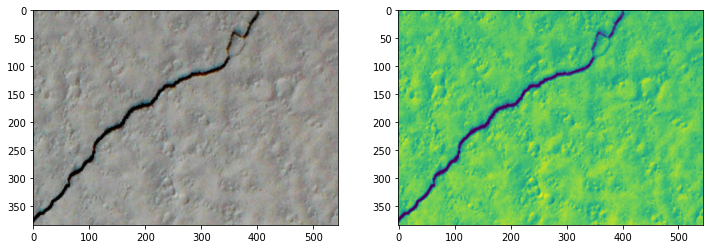

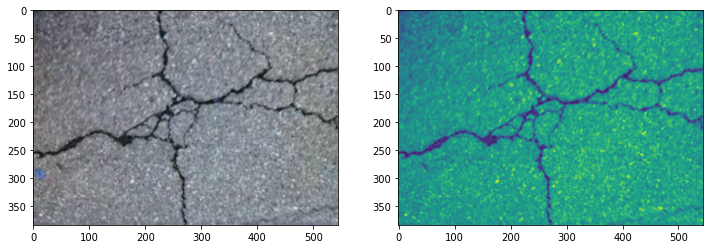

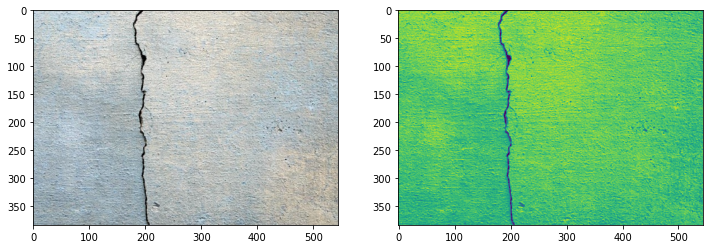

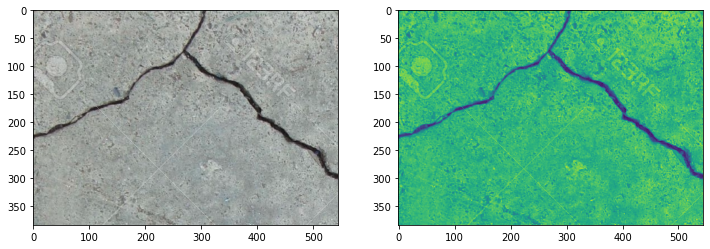

In [58]:
#Another Sanity check, view few mages
def randome_plot(images,masks,N,ftype="files"):

    
    for _ in range(N):
        image_number = random.randint(0, len(images))
        if ftype=="files":
            img=cv2.imread(images[image_number])
            label=cv2.imread(images[image_number],0)
        else:
            img=images[image_number]
            label=masks[image_number ]
            
        
        plt.figure(figsize=(12, 6))
        plt.subplot(121)
        plt.imshow(img)
        plt.subplot(122)
        plt.imshow(label)
        plt.show()
randome_plot(train_files,train_labels,4,)

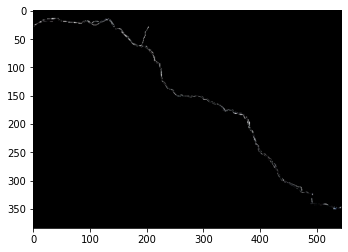

In [23]:
test_img=img.copy()
test_img[label==0]=0
plt.imshow(test_img)

## Global setting グロブルの設定

In [65]:
print(img.shape)
dim=img.shape
IMG_HEIGHT=128 #dim[0] #256
IMG_WIDTH=128 #dim[1]  # 256
IMG_CHANNELS=3
n_classes=1

(384, 544, 3)


## 訓練のデータを準備

In [86]:
img=cv2.imread(train_labels[0],0)
img.shape

(384, 544)

In [162]:
#訓練のデータを作成 X : Vectors (images) Y : labels (location boolien)

def Readfiles(files,Gray=False,Patch=False,patch_size=128):
    out_images=[]
    for n,f in tqdm(enumerate(files),total=len(files)):
    #img = imread(f)[:,:,:IMG_CHANNELS]  
        if GRAY:
            img=cv2.imread(f,0)
            c=1
        else:
            img=cv2.imread(f,1)
            c=3
        if Patch:
            SIZE_X = (img.shape[1]//patch_size)*patch_size #Nearest size divisible by our patch size
            SIZE_Y = (img.shape[0]//patch_size)*patch_size #Nearest size divisible by our patch size
            img=img[0:SIZE_Y,0:SIZE_X,:]
            if GRAY:
                patches_img = patchify(img, (patch_size, patch_size), step=patch_size)  #Step=256 for 256 patches means no overlap
                dim_p=patches_img.shape
                patches_img=patches_img.reshape(np.prod(dim_p[0:3]),dim_p[3],dim_p[4],1)
            else:
                patches_img = patchify(img, (patch_size, patch_size, 3), step=patch_size)  #Step=256 for 256 patches means no overlap
                dim_p=patches_img.shape
                patches_img=patches_img.reshape(np.prod(dim_p[0:3]),dim_p[3],dim_p[4],dim_p[5])
                
                
            for img in patches_img:
                out_images.append(img)
            #np.sum(patches.shape[0:3])
            #return patches_img
        else:    
            out_images.append(img)
    print( dim_p)
    return np.array(out_images)
  
train_I=Readfiles(train_files,Patch=True)
train_L=Readfiles(train_labels,Patch=True,Gray=True)[:,:,:,0]
dim_L=train_L.shape
train_L=train_L.reshape(dim_L[0],dim_L[1],dim_L[2],1)

100%|█████████████████████████████████████████████████████████████| 300/300 [00:00<00:00, 429.03it/s]


(3, 4, 1, 128, 128, 3)


100%|████████████████████████████████████████████████████████████| 300/300 [00:00<00:00, 1176.04it/s]

(3, 4, 1, 128, 128, 3)


In [163]:
train_I.shape,train_L.shape

((3600, 128, 128, 3), (3600, 128, 128, 1))

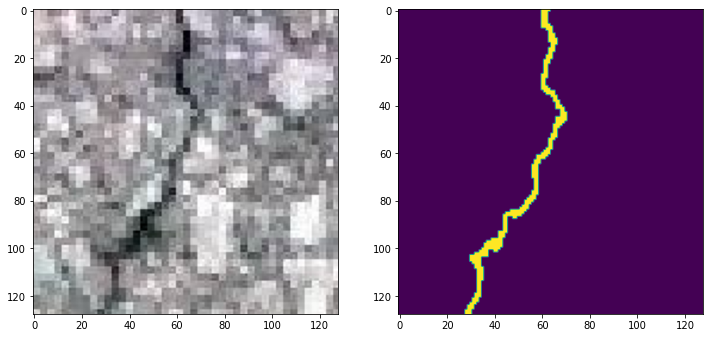

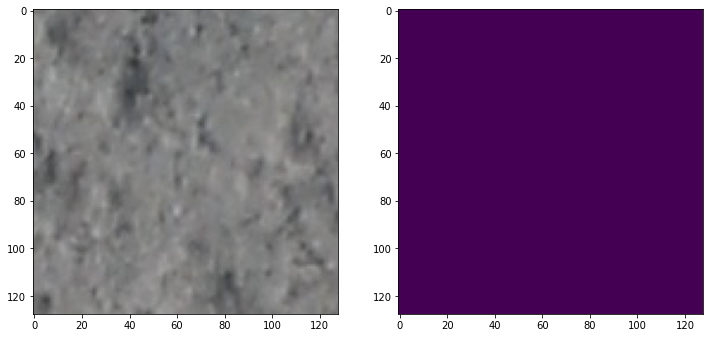

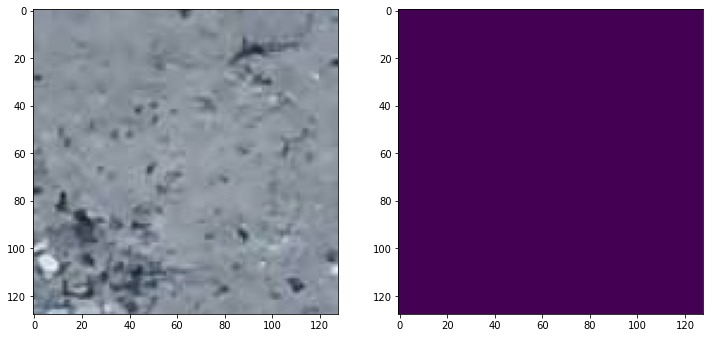

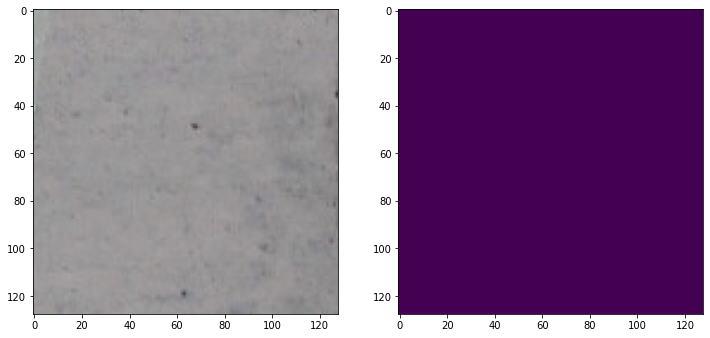

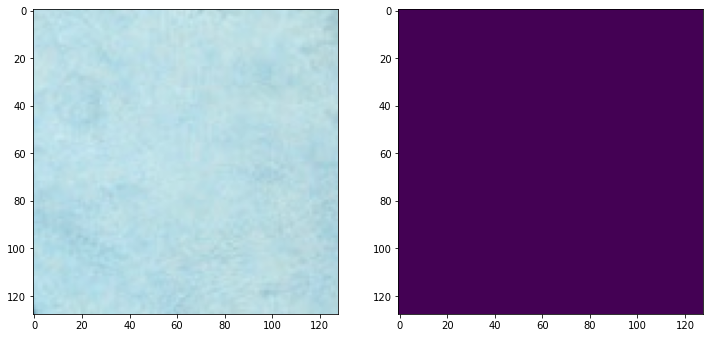

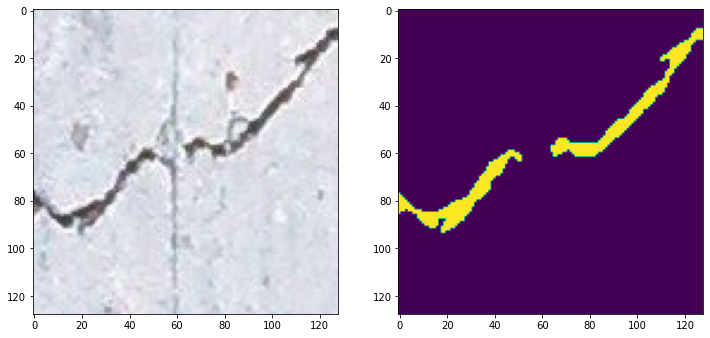

In [164]:
randome_plot(train_I,train_L,6,ftype="array")

In [165]:
#Threshholds 
np.unique(train_L)
train_L[train_L==255]=1

In [159]:
#MaxScaler Images normalization 正規化
from sklearn.preprocessing import MinMaxScaler
Scaler = MinMaxScaler()
dim=train_I.shape
train_I=Scaler.fit_transform(train_I.reshape(-1,3)).reshape(dim)

X_test=

In [174]:
train_I=Scaler.fit_transform(train_I.reshape(-1,3)).reshape(dim)
train_I

array([[[[0.34117647, 0.34901961, 0.35294118],
         [0.3372549 , 0.34509804, 0.34901961],
         [0.33333333, 0.34117647, 0.34509804],
         ...,
         [0.63921569, 0.63529412, 0.64313725],
         [0.64313725, 0.63921569, 0.64705882],
         [0.64313725, 0.63921569, 0.64705882]],

        [[0.35294118, 0.36078431, 0.36470588],
         [0.34901961, 0.35686275, 0.36078431],
         [0.34117647, 0.34901961, 0.35294118],
         ...,
         [0.64313725, 0.63921569, 0.64705882],
         [0.64313725, 0.63921569, 0.64705882],
         [0.64313725, 0.63921569, 0.64705882]],

        [[0.37647059, 0.38431373, 0.38823529],
         [0.37254902, 0.38039216, 0.38431373],
         [0.36862745, 0.37647059, 0.38039216],
         ...,
         [0.64313725, 0.63921569, 0.64705882],
         [0.64313725, 0.63921569, 0.64705882],
         [0.63921569, 0.63529412, 0.64313725]],

        ...,

        [[0.63921569, 0.63529412, 0.64313725],
         [0.65490196, 0.65098039, 0.65882353]

In [175]:
#UseFull Check
train_I.shape,train_L.shape
NoCrack=[]
X_train=[]
y_train=[]

for i in range(len(train_L)):
    val,counts=np.unique(train_L[i],return_counts=True)
    if len(val)>1:
        if counts[1]>100:
            y_train.append(train_L[i])
            X_train.append(train_I[i])
    else:
        NoCrack.append(train_I[i])
        
print(f"Usefull images {len(X_train)}/{len(train_I)}")
X_train=np.array(X_train)
y_train=np.array(y_train)
NoCrack=np.array(NoCrack)


Usefull images 1654/3600


In [176]:
X_train.shape,y_train.shape

((1654, 128, 128, 3), (1654, 128, 128, 1))

In [246]:
#Data generator 
from keras.preprocessing.image import ImageDataGenerator

datagen = ImageDataGenerator(
    featurewise_center=True,
    featurewise_std_normalization=True,
    rotation_range=20,
    width_shift_range=0.2,
    height_shift_range=0.2,
    horizontal_flip=True,
    fill_mode="reflect",
)


In [177]:
datagen.__next__()

array([[[[0.34117647, 0.34901961, 0.35294118],
         [0.3372549 , 0.34509804, 0.34901961],
         [0.33333333, 0.34117647, 0.34509804],
         ...,
         [0.63921569, 0.63529412, 0.64313725],
         [0.64313725, 0.63921569, 0.64705882],
         [0.64313725, 0.63921569, 0.64705882]],

        [[0.35294118, 0.36078431, 0.36470588],
         [0.34901961, 0.35686275, 0.36078431],
         [0.34117647, 0.34901961, 0.35294118],
         ...,
         [0.64313725, 0.63921569, 0.64705882],
         [0.64313725, 0.63921569, 0.64705882],
         [0.64313725, 0.63921569, 0.64705882]],

        [[0.37647059, 0.38431373, 0.38823529],
         [0.37254902, 0.38039216, 0.38431373],
         [0.36862745, 0.37647059, 0.38039216],
         ...,
         [0.64313725, 0.63921569, 0.64705882],
         [0.64313725, 0.63921569, 0.64705882],
         [0.63921569, 0.63529412, 0.64313725]],

        ...,

        [[0.63921569, 0.63529412, 0.64313725],
         [0.65490196, 0.65098039, 0.65882353]

# モデル: Unet

In [142]:
d

array([0, 1], dtype=uint8)

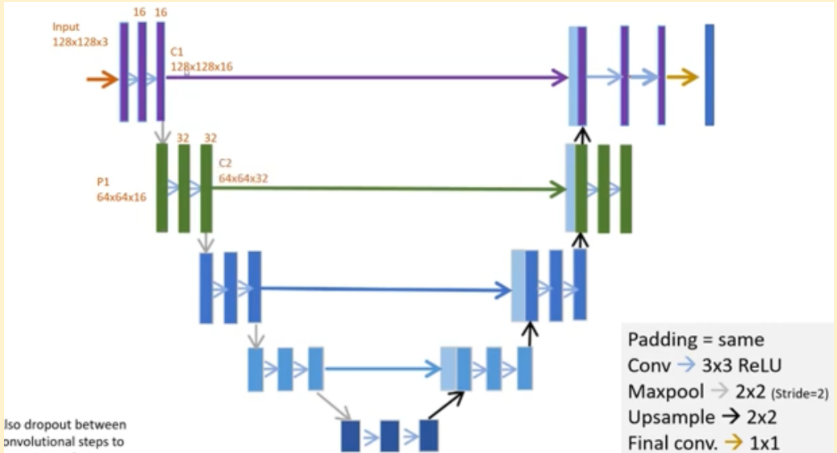

In [180]:
#Standard U Net 
from keras import backend as K
def jacard_coef(y_true, y_pred):
    y_true_f = K.flatten(y_true)
    y_pred_f = K.flatten(y_pred)
    intersection = K.sum(y_true_f * y_pred_f)
    return (intersection + 1.0) / (K.sum(y_true_f) + K.sum(y_pred_f) - intersection + 1.0)


def model_UNET(imagesize=(IMG_WIDTH,IMG_HEIGHT,IMG_CHANNELS),weights_input=None):

    inputs = inputs = tf.keras.layers.Input(imagesize)
    conv1 = tf.keras.layers.Conv2D(64, 3, activation="relu", padding="same", kernel_initializer="he_normal")(inputs)
    conv1 = tf.keras.layers.Conv2D(64, 3, activation="relu", padding="same", kernel_initializer="he_normal")(conv1)
    pool1 =tf.keras.layers.MaxPooling2D(pool_size=(2, 2))(conv1)

    conv2 =tf.keras.layers.Conv2D(128, 3, activation="relu", padding="same", kernel_initializer="he_normal")(pool1)
    conv2 =tf.keras.layers.Conv2D(128, 3, activation="relu", padding="same", kernel_initializer="he_normal")(conv2)
    pool2 =tf.keras.layers.MaxPooling2D(pool_size=(2, 2))(conv2)

    conv3 =tf.keras.layers.Conv2D(256, 3, activation="relu", padding="same", kernel_initializer="he_normal")(pool2)
    conv3 =tf.keras.layers.Conv2D(256, 3, activation="relu", padding="same", kernel_initializer="he_normal")(conv3)
    pool3 =tf.keras.layers.MaxPooling2D(pool_size=(2, 2))(conv3)

    conv4 = tf.keras.layers.Conv2D(512, 3, activation="relu", padding="same", kernel_initializer="he_normal")(pool3)
    conv4 = tf.keras.layers.Conv2D(512, 3, activation="relu", padding="same", kernel_initializer="he_normal")(conv4)
    drop4 = tf.keras.layers.Dropout(0.5)(conv4)
    pool4 = tf.keras.layers.MaxPooling2D(pool_size=(2, 2))(drop4)

    conv5 = tf.keras.layers.Conv2D(1024, 3, activation="relu", padding="same", kernel_initializer="he_normal")(pool4)
    conv5 = tf.keras.layers.Conv2D(1024, 3, activation="relu", padding="same", kernel_initializer="he_normal")(conv5)
    drop5 = tf.keras.layers.Dropout(0.5)(conv5)
    #Expansive path Back up 拡張経路　
    up6 = tf.keras.layers.Conv2D(512, 2, activation="relu", padding="same", kernel_initializer="he_normal")( tf.keras.layers.UpSampling2D(size = (2,2))(drop5))
    merge6 = tf.keras.layers.Concatenate(axis=3)([drop4,up6])
    conv6 = tf.keras.layers.Conv2D(512, 3, activation="relu", padding="same", kernel_initializer="he_normal")(merge6)
    conv6 = tf.keras.layers.Conv2D(512, 3, activation="relu", padding="same", kernel_initializer="he_normal")(conv6)

    up7 = tf.keras.layers.Conv2D(256, 2, activation="relu", padding="same", kernel_initializer="he_normal")(tf.keras.layers.UpSampling2D(size = (2,2))(conv6))
    merge7 = tf.keras.layers.Concatenate(axis=3)([conv3,up7])
    conv7 =tf.keras.layers.Conv2D(256, 3, activation="relu", padding="same", kernel_initializer="he_normal")(merge7)
    conv7 = tf.keras.layers.Conv2D(256, 3, activation="relu", padding="same", kernel_initializer="he_normal")(conv7)

    up8 = tf.keras.layers.Conv2D(128, 2, activation="relu", padding="same", kernel_initializer="he_normal")(tf.keras.layers.UpSampling2D(size = (2,2))(conv7))
    merge8 = tf.keras.layers.Concatenate(axis=3)([conv2,up8])
    conv8 = tf.keras.layers.Conv2D(128, 3, activation="relu", padding="same", kernel_initializer="he_normal")(merge8)
    conv8 = tf.keras.layers.Conv2D(128, 3, activation="relu", padding="same", kernel_initializer="he_normal")(conv8)

    up9 = tf.keras.layers.Conv2D(64, 2, activation="relu", padding="same", kernel_initializer="he_normal")(tf.keras.layers.UpSampling2D(size = (2,2))(conv8))
    merge9 = tf.keras.layers.Concatenate(axis=3)([conv1,up9])
    conv9 = tf.keras.layers.Conv2D(64, 3, activation="relu", padding="same", kernel_initializer="he_normal")(merge9)
    conv9 =tf.keras.layers.Conv2D(64, 3, activation="relu", padding="same", kernel_initializer="he_normal")(conv9)
    conv9 = tf.keras.layers.Conv2D(2, 3, activation="relu", padding="same", kernel_initializer="he_normal")(conv9)

    conv10 = tf.keras.layers.Conv2D(1, 1, activation="sigmoid")(conv9)

    model = tf.keras.Model(inputs=inputs, outputs=conv10)
    model.compile(optimizer=tf.keras.optimizers.Adam(lr=1e-4), loss="binary_crossentropy", metrics=["accuracy", jacard_coef])

    if weights_input:
        model.load_weights(weights_input)
    model.summary()
    return model

UNET=model_UNET()


Model: "model_9"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_10 (InputLayer)           [(None, 128, 128, 3) 0                                            
__________________________________________________________________________________________________
conv2d_236 (Conv2D)             (None, 128, 128, 64) 1792        input_10[0][0]                   
__________________________________________________________________________________________________
conv2d_237 (Conv2D)             (None, 128, 128, 64) 36928       conv2d_236[0][0]                 
__________________________________________________________________________________________________
max_pooling2d_41 (MaxPooling2D) (None, 64, 64, 64)   0           conv2d_237[0][0]                 
____________________________________________________________________________________________

/home/jarvis/anaconda3/envs/tf_gpu_env/lib/python3.8/site-packages/keras/optimizer_v2/optimizer_v2.py:355: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  warnings.warn(


## Model checkpoint settings モデルを確認するところの設定

In [245]:
checkpointer = tf.keras.callbacks.ModelCheckpoint("model_for_cracks.h5",verbose=1,save_best_only=True)

callbacks = [
          #   tf.keras.callbacks.EarlyStopping(patience=5,monitor="val_loss"),
             tf.keras.callbacks.TensorBoard(log_dir="./logs"),
                checkpointer 
]

%load_ext tensorboard
%tensorboard --logdir logs --host=192.168.0.13 --port=6005

2021-10-10 13:26:17.768918: I tensorflow/core/profiler/lib/profiler_session.cc:131] Profiler session initializing.
2021-10-10 13:26:17.768961: I tensorflow/core/profiler/lib/profiler_session.cc:146] Profiler session started.


The tensorboard extension is already loaded. To reload it, use:
  %reload_ext tensorboard


2021-10-10 13:26:18.189037: I tensorflow/core/profiler/lib/profiler_session.cc:164] Profiler session tear down.
2021-10-10 13:26:18.189424: I tensorflow/core/profiler/internal/gpu/cupti_tracer.cc:1748] CUPTI activity buffer flushed


## Moddeling fitting モデル

訓練のデータはモデルに入り込んで、訓練を行う。

In [181]:
    
epochs=50
batch_size=50
import datetime
models={"UNET":UNET}
model_results={}
if not os.path.exists("./models"):
    os.makedir("./models")
    os.makedir("./models/results")


In [182]:
#Results view 
def compare_TV(history,savepath,modelname,BATCH_SIZE=batch_size,EPOCHS=epochs):

      #  X_test,y_test=val_img_gen.__next__()

        import matplotlib.pyplot as plt
        if not os.path.exists(savepath):
              os.makedirs(savepath)
        keys=list(history.history.keys())
        VAL=False
        if "val_loss" in keys:
            VAL=True
            keys=list([k for k in keys if "val" not in k])
        
        
        for key in keys:
            score=history.history[key]
            epochs=range(len(score))
            
            plt.plot(epochs, score, 'bo' ,label = f'training {key}')
            if VAL:
                plt.plot(epochs,history.history[f"val_{key}"], 'b' , label= f'validation {key}')
            
            plt.title(modelname+ "\n"+key)
            plt.legend()
            plt.savefig(f'{savepath}/{key}_{modelname}_{EPOCHS:03d}_{BATCH_SIZE:03d}.png')
            plt.figure()


========================= model UNET =========================
UNET
Epoch 1/50
 1/30 [>.............................] - ETA: 14s - loss: 0.1698 - accuracy: 0.9336 - jacard_coef: 0.1292

2021-10-10 13:59:57.039040: I tensorflow/core/profiler/lib/profiler_session.cc:131] Profiler session initializing.
2021-10-10 13:59:57.039087: I tensorflow/core/profiler/lib/profiler_session.cc:146] Profiler session started.


 2/30 [=>............................] - ETA: 28s - loss: 0.1610 - accuracy: 0.9370 - jacard_coef: 0.1274

2021-10-10 13:59:58.019878: I tensorflow/core/profiler/lib/profiler_session.cc:66] Profiler session collecting data.
2021-10-10 13:59:58.020347: I tensorflow/core/profiler/internal/gpu/cupti_tracer.cc:1748] CUPTI activity buffer flushed
2021-10-10 13:59:58.091003: I tensorflow/core/profiler/internal/gpu/cupti_collector.cc:673]  GpuTracer has collected 657 callback api events and 656 activity events. 
2021-10-10 13:59:58.108822: I tensorflow/core/profiler/lib/profiler_session.cc:164] Profiler session tear down.
2021-10-10 13:59:58.124233: I tensorflow/core/profiler/rpc/client/save_profile.cc:136] Creating directory: ./logs/train/plugins/profile/2021_10_10_13_59_58

2021-10-10 13:59:58.133176: I tensorflow/core/profiler/rpc/client/save_profile.cc:142] Dumped gzipped tool data for trace.json.gz to ./logs/train/plugins/profile/2021_10_10_13_59_58/jarvis-System-Product-Name.trace.json.gz
2021-10-10 13:59:58.162605: I tensorflow/core/profiler/rpc/client/save_profile.cc:136] Creating director

30/30 [==============================] - 15s 483ms/step - loss: 0.1051 - accuracy: 0.9611 - jacard_coef: 0.2921 - val_loss: 0.0642 - val_accuracy: 0.9786 - val_jacard_coef: 0.2890

Epoch 00001: val_loss improved from inf to 0.06417, saving model to model_for_cracks.h5
Epoch 2/50
30/30 [==============================] - 14s 457ms/step - loss: 0.0765 - accuracy: 0.9777 - jacard_coef: 0.3852 - val_loss: 0.0607 - val_accuracy: 0.9796 - val_jacard_coef: 0.3203

Epoch 00002: val_loss improved from 0.06417 to 0.06068, saving model to model_for_cracks.h5
Epoch 3/50
30/30 [==============================] - 14s 457ms/step - loss: 0.0726 - accuracy: 0.9796 - jacard_coef: 0.4000 - val_loss: 0.0580 - val_accuracy: 0.9810 - val_jacard_coef: 0.3363

Epoch 00003: val_loss improved from 0.06068 to 0.05796, saving model to model_for_cracks.h5
Epoch 4/50
30/30 [==============================] - 14s 458ms/step - loss: 0.0710 - accuracy: 0.9803 - jacard_coef: 0.4050 - val_loss: 0.0561 - val_accuracy: 0.981

30/30 [==============================] - 14s 461ms/step - loss: 0.0526 - accuracy: 0.9890 - jacard_coef: 0.4875 - val_loss: 0.0582 - val_accuracy: 0.9836 - val_jacard_coef: 0.3924

Epoch 00033: val_loss did not improve from 0.05279
Epoch 34/50
30/30 [==============================] - 14s 460ms/step - loss: 0.0526 - accuracy: 0.9890 - jacard_coef: 0.4878 - val_loss: 0.0585 - val_accuracy: 0.9839 - val_jacard_coef: 0.3963

Epoch 00034: val_loss did not improve from 0.05279
Epoch 35/50
30/30 [==============================] - 14s 462ms/step - loss: 0.0523 - accuracy: 0.9891 - jacard_coef: 0.4890 - val_loss: 0.0655 - val_accuracy: 0.9830 - val_jacard_coef: 0.3872

Epoch 00035: val_loss did not improve from 0.05279
Epoch 36/50
30/30 [==============================] - 14s 461ms/step - loss: 0.0521 - accuracy: 0.9891 - jacard_coef: 0.4900 - val_loss: 0.0702 - val_accuracy: 0.9833 - val_jacard_coef: 0.3886

Epoch 00036: val_loss did not improve from 0.05279
Epoch 37/50
30/30 [=================

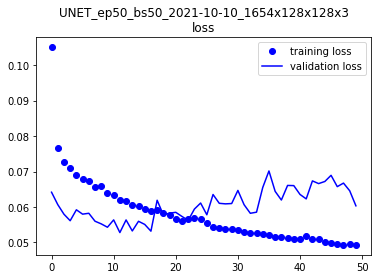

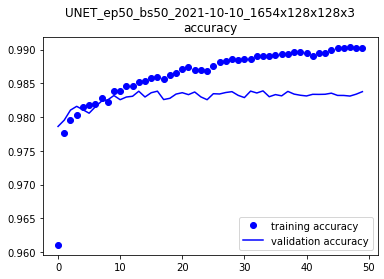

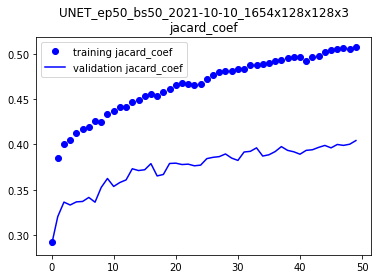

<Figure size 432x288 with 0 Axes>

In [256]:

models={"UNET":UNET}
model_results={}
if not os.path.exists("./models"):
    os.makedir("./models")
    os.makedir("./models/results")
savepath="./models"



epochs=50
batch_size=50
DATE=datetime.datetime.today().date().__str__()
for key,model in models.items():
    print(f'{"="*25} model {key} {"="*25}')
    print(key)
    
    
   # model.fit_generator(
    #    datagen.flow(X_train, y_train, batch_size=batch_size),
     #   steps_per_epoch=len(X_train) / batch_size, epochs=epochs,
      #  callbacks=callbacks, verbose=1 )
    
    
    
    results = model.fit(
        X_train,
        y_train,
        validation_split=0.1
        ,batch_size=batch_size,
        epochs=epochs,
        callbacks=callbacks,
        verbose=1
        )
   
    modelname= f"{key}_ep{epochs}_bs{batch_size}_{DATE}_{len(X_train)}x{IMG_HEIGHT}x{IMG_WIDTH}x{IMG_CHANNELS}"
    model.save(f'{savepath}/{modelname}.h5')
             
    compare_TV(results,f"{savepath}/results",modelname)
    model_results[key]=results


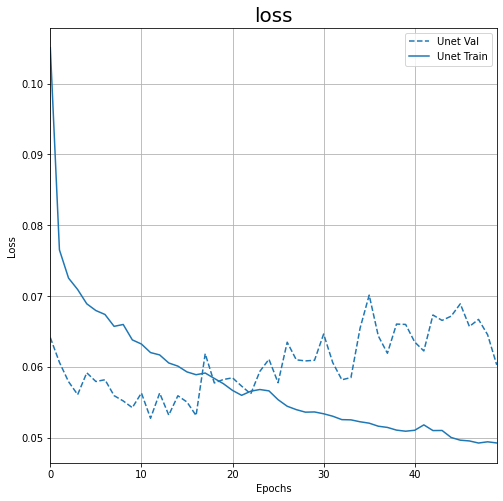

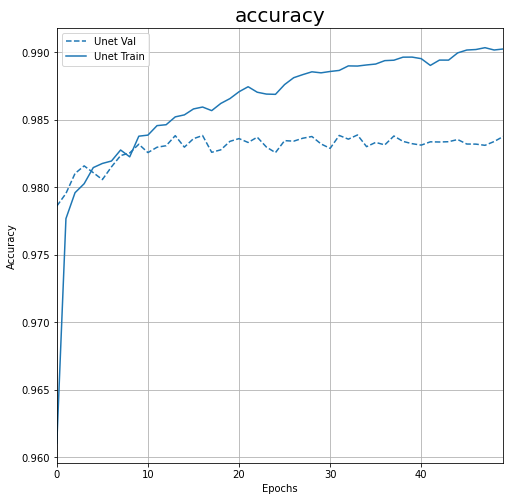

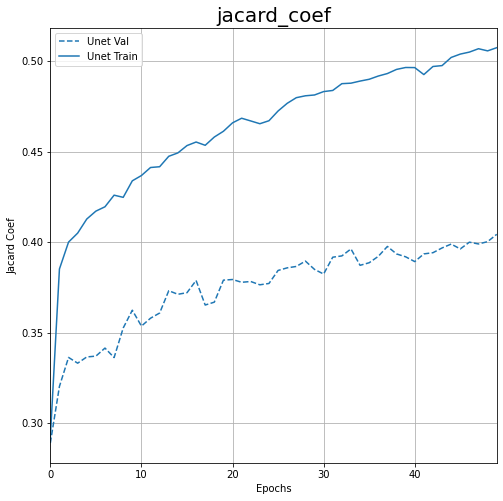

In [257]:
def plot_history(results, keys=['loss', 'accuracy','jacard_coef']):
  for key in keys:
    plt.figure(figsize=(8,8))
    for name, history in results.items():
      val = plt.plot(history.epoch, history.history["val_"+key],
                    '--', label=name.title()+' Val')
      plt.plot(history.epoch, history.history[key], color=val[0].get_color(),
              label=name.title()+' Train')
    plt.title(key,fontsize=20)
    plt.xlabel('Epochs')
    plt.ylabel(key.replace('_',' ').title())
    plt.legend()
    plt.xlim([0,max(history.epoch)])
    plt.grid()
plot_history(model_results)

In [249]:
model_result={}
model_result["Unet"]=model_results["Unet"]
plot_history(model_result)

KeyError: 'Unet'

In [250]:
model_results.keys()

dict_keys([])

## Predict Test data テストのデータを予想する

In [227]:
X_test=[]
for f in test_files:
    img=cv2.imread(f,1)
    X_test.append(img)

X_test=np.array(X_test)
dims=X_test.shape

X_test=Scaler.fit_transform(X_test.reshape(-1,dim[~0])).reshape(dims)


#train_I=Scaler.fit_transform(train_I.reshape(-1,3)).reshape(dim)


/tmp/ipykernel_3956/677479691.py:5: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  X_test=np.array(X_test)


========================= model UNET =========================


100%|██████████████████████████████████████████████████████████████████| 8/8 [00:08<00:00,  1.03s/it]


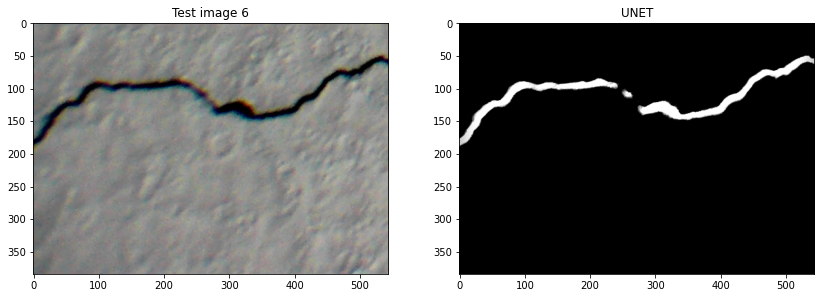

In [259]:
from smooth_tiled_predictions import predict_img_with_smooth_windowing

pred_tests={}

patch_size=128
n_classes=1


ix=random.randint(0,len(X_test))
for key,model in models.items():
  print(f'{"="*25} model {key} {"="*25}')
  #pred_tests[key]=model.predict(X_test,verbose=2)
  
  pred_tests[key] = predict_img_with_smooth_windowing(
    X_test[ix],
    window_size=patch_size,
    subdivisions=2,  # Minimal amount of overlap for windowing. Must be an even number.
    nb_classes=n_classes,
    pred_func=(
        lambda img_batch_subdiv: model.predict((img_batch_subdiv))
    )
)
 

figs,axs=plt.subplots(1,len(models)+1,figsize=(14,8))
i=1
axs[0].imshow(X_test[ix],"gray")
axs[0].set_title(f"Test image {ix}")
for key,pred in pred_tests.items():
  #print(key)
  axs[i].imshow(pred,cmap="gray")
  axs[i].set_title(key)
  i+=1

 # Extract crack contours and conver to a dfx file画像の亀裂の輪郭を抽出して、dfxのファイルへ変換する

In [260]:
#モデルの予想の画像は正規化から戻る
def prepare_output(image):
    image = image[:,:,0]
    image = np.clip(image, 0, 1)
    return np.multiply(image, 255)
#表示
def imshow_ccbar(image,cmap="reds",title=None):
  plt.figure()
  im=plt.imshow(image)
  plt.colorbar(im,cmap=cmap)
  if title:
    plt.title(title)
  plt.show()
  
#閾値
def threshold(image, min_limit=None, max_limit=256, clip=0):
    if min_limit is None:
        min_limit = int(np.mean(image) + clip)

    _, image = cv2.threshold(image, min_limit, max_limit, cv2.THRESH_BINARY)
    return image
#輪郭を抽出する
def predToContours(img_pred,img_original,thresh_mim=55,MIN_C=20,plot=False):
  #正規化から0-255の数へ変換する
  img_p1=prepare_output(img_pred)
  if plot:
    imshow_ccbar(img_p1,title="0-255")
  #平滑化 ぼかし
  img_p2 = cv2.GaussianBlur(img_p1,(3,3), 1)
  if plot:
    imshow_ccbar(img_p2,title="GaussianBlur")
  #閾値
  img_p3 = threshold(img_p2, min_limit=thresh_mim)
  if plot:
     imshow_ccbar(img_p3,title="threshhold")
  
  #輪郭の機能で扱いデータの形式 uint8へ変換する
  img_p3=cv2.convertScaleAbs(img_p3)
  #輪郭
  contours, hierarchy = cv2.findContours(img_p3,cv2.RETR_TREE,cv2.CHAIN_APPROX_SIMPLE)
  #小さいな輪郭を抜ける
  usecontours=[]
  
  for contour in contours:
    if len(contour)>=MIN_C:
      usecontours.append(contour)
  if plot:
    new_img=cv2.drawContours(img_original,usecontours,-1,color=(0,0,255),thickness=2)
    plt.figure()
    plt.imshow(new_img,cmap="gray")
    plt.title("Contours")
  return usecontours

#輪郭からdxfのファイルを変換する
def ContoursToDxf(contours,savename):
    #dxf file creation dxfのファイルを作成する
    dwg = ezdxf.new("R2010")
    msp = dwg.modelspace()
    #亀裂のレイヤーを作成
    dwg.layers.new(name="Crack",dxfattribs={"color":3})
    #Add contors to dxf dfxには輪郭を加える

    for ctr in contours:
        for i in range(len(ctr)):
            j= i+1
            if j>=len(ctr):
                j=0
            try:
                msp.add_line(ctr[i][0],ctr[j][0], dxfattribs={'layer':"Crack"})
            except Exception as e:
                print(ctr[i],'->',ctr[j])
                print(e.args)

    dwg.saveas(f'{savename}.dxf')

dict_keys(['UNET'])

100%|██████████████████████████████████████████████████████████████████| 8/8 [00:08<00:00,  1.03s/it]
/tmp/ipykernel_3956/2558398260.py:10: MatplotlibDeprecationWarning: The 'cmap' parameter to Colorbar has no effect because it is overridden by the mappable; it is deprecated since 3.3 and will be removed two minor releases later.
  plt.colorbar(im,cmap=cmap)


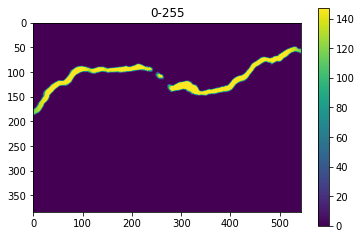

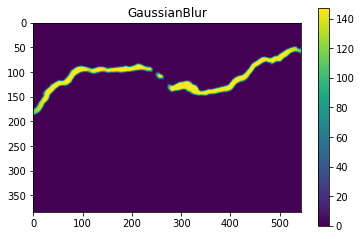

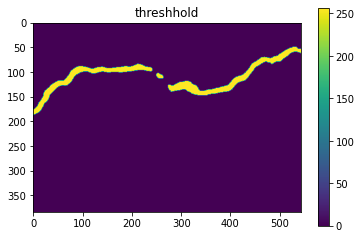

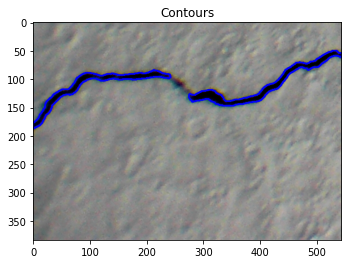

In [264]:
#Random test images ランダムの画像とテスト
ix=random.randint(0,len(X_test))
img_original=X_test[ix]
model= models["UNET"]
 
pred_img= predict_img_with_smooth_windowing(
    img_original,
    window_size=patch_size,
    subdivisions=2,  # Minimal amount of overlap for windowing. Must be an even number.
    nb_classes=n_classes,
    pred_func=(
        lambda img_batch_subdiv: model.predict((img_batch_subdiv))
        )
)


savename = f"test_crack_%003d_{key}" % (ix)
contours=predToContours(pred_img,np.squeeze(img_original),MIN_C=20,plot=True)
ContoursToDxf(contours,savename)
